In [65]:
# importing libraries
import numpy as np
import pandas as pd
import os
import re
import random
import sklearn
import copy

# For Splitting the data into training and testing
from sklearn.model_selection import train_test_split

# For Plotting data
import matplotlib.pyplot as plt
import seaborn as sns

# Importing natural lenguage toolkit
import nltk

# Tensorflow and keras to run the model on.
import tensorflow as tf
from tensorflow import keras

## Importing Dataset

In [66]:
df=pd.read_csv("/content/drive/MyDrive/transliteration.csv")

In [67]:
df.head() # check first five rows

,Punjabi,English
0,ਅੱਜਕੱਲ੍ਹ,ajjkallh
1,ਕੁੱਕਰੀ,kookerii
2,ਧਮਨੀਆਂ,dhamniyan
3,ਖ਼ੁਦਗ਼ਰਜ਼ੀ,khudgarzi
4,ਅਗਲੇਰਾ,aglera


In [68]:
df.shape # check number of rows and columns

(514724, 2)

In [69]:
df.isnull().sum() # check missing values

Punjabi    0
English    2
dtype: int64

In [70]:
df.dropna(inplace=True) # droping null values

In [71]:
X = df['Punjabi']
y = df['English']

In [72]:
final_punjabi_words= X.apply(lambda x: '@' + x.strip() + '#')
final_english_words= y.apply(lambda x: '@' + x.strip() + '#')

In [73]:
final_punjabi_words=list(final_punjabi_words)
final_english_words=list(final_english_words)

In [74]:
(final_punjabi_words[11],final_english_words[11])

('@ਲਹੌਰ#', '@lahor#')

In [75]:
len(final_punjabi_words),len(final_english_words)

(514722, 514722)

### In any NLP task First Step is to Create the vocab of the words, so First we will Create the dictonaries like ```vocab_to_index``` and ```index_to_vocab``` for both the languages ```punjabi``` and ```english``` they are known as ```lookup_tables```

In [2]:
class Word2Index():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      for l in phrase:
        self.vocab.update(l)
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word
      

In [76]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(final_punjabi_words,final_english_words):


    # index language using the class defined above    
    punjabi_lang = Word2Index(final_punjabi_words)
    english_lang = Word2Index(final_english_words)
    
    # Vectorize the input and target languages
    
    # English words
    input_tensor = [[punjabi_lang.word2idx[s] for s in hn] for hn in final_punjabi_words]
    
    # hindi words
    target_tensor = [[english_lang.word2idx[s] for s in en] for en in final_english_words]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, punjabi_lang, english_lang, max_length_inp, max_length_tar

In [77]:
punjabi_tensor, english_tensor, english_lang, punjabi_lang, max_length_english, max_length_hindi = load_dataset(final_punjabi_words,final_english_words)

In [78]:
punjabi_tensor[0]

array([ 2,  4, 58, 21, 14, 58, 41, 55, 44,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

**Saving the tensors model**

In [6]:
# create lookup tables for English and Punjabi data

punjabi_vocab_to_int, punjabi_int_to_vocab = punjabi_lang.word2idx,punjabi_lang.idx2word
English_vocab_to_int, english_int_to_vocab = english_lang.word2idx,english_lang.idx2word

**Model Building**

## Split the data into train and test

In [79]:
punjabi_tensor_train, punjabi_tensor_test, english_tensor_train,english_tensor_test = train_test_split(punjabi_tensor, english_tensor, test_size=0.10,random_state=42)

In [80]:
len(punjabi_tensor_train),len(punjabi_tensor_test),len(english_tensor_train),len(english_tensor_test)

(463249, 51473, 463249, 51473)

In [81]:
max_length_punjabi,max_length_english

(24, 29)

# Defining Bidirectional LSTM Models for Neural Machine Traslation

In [82]:
from keras.models import Model,Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,RepeatVector,add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Setting-up Hyper parameters

In [14]:
punjabi_vocab_size = len(punjabi_vocab_to_int)+1
english_vocab_size = len(English_vocab_to_int)+1

punjabi_vocab_size,english_vocab_size

(61, 35)

In [83]:
punjabi_tensor.shape

(514722, 24)

In [84]:
english_tensor.shape

(514722, 29)

# Defining Model

In [127]:
def model_final(input_shape, output_sequence_length, punjabi_vocab_size, english_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param punjabi_vocab_size: Number of unique punjabi words in the dataset
    :param english_vocab_size: Number of unique english words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    learning_rate = 0.003
    
    # Build the layers    
    model = Sequential()
    # Embedding
    model.add(Embedding(punjabi_vocab_size, 128, input_length=input_shape[1],
                         input_shape=input_shape[1:]))
    # Encoder
    model.add(Bidirectional(LSTM(128)))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(english_vocab_size, activation='softmax')))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(learning_rate),
                  metrics=['accuracy'])
    return model

In [86]:
print(punjabi_tensor_train.shape)
print(english_tensor_train.shape)

(463249, 24)
(463249, 29)


In [128]:

model = model_final(punjabi_tensor_train.shape,english_tensor_train.shape[1],punjabi_vocab_size,english_vocab_size)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 24, 128)           7808      
                                                                 
 bidirectional_24 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 repeat_vector_8 (RepeatVect  (None, 29, 256)          0         
 or)                                                             
                                                                 
 bidirectional_25 (Bidirecti  (None, 29, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 29, 256)          394240    
 onal)                                                

## Fitting The Model

In [129]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Punjabi transliteration/NMT_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy',patience=2,verbose = 1, mode ='max',restore_best_weights = True)


history = model.fit(punjabi_tensor_train, english_tensor_train, batch_size=512,validation_split=0.2,epochs=30,callbacks = [checkpoint,early_stopping])

Epoch 1/30
723/724 [============================>.] - ETA: 0s - loss: 0.9104 - accuracy: 0.7445
Epoch 1: val_loss improved from inf to 0.68910, saving model to /content/drive/MyDrive/Punjabi transliteration/NMT_model.hdf5
724/724 [==============================] - 58s 64ms/step - loss: 0.9101 - accuracy: 0.7446 - val_loss: 0.6891 - val_accuracy: 0.7853
Epoch 2/30
723/724 [============================>.] - ETA: 0s - loss: 0.6041 - accuracy: 0.8073
Epoch 2: val_loss improved from 0.68910 to 0.47547, saving model to /content/drive/MyDrive/Punjabi transliteration/NMT_model.hdf5
724/724 [==============================] - 40s 55ms/step - loss: 0.6040 - accuracy: 0.8073 - val_loss: 0.4755 - val_accuracy: 0.8418
Epoch 3/30
723/724 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.8496
Epoch 3: val_loss improved from 0.47547 to 0.37349, saving model to /content/drive/MyDrive/Punjabi transliteration/NMT_model.hdf5
724/724 [==============================] - 40s 55ms/step - l

## Plotting Some graph

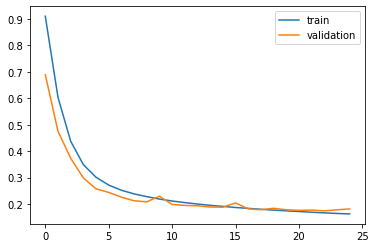

<Figure size 432x288 with 0 Axes>

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
plt.savefig('trai_validation_loss')

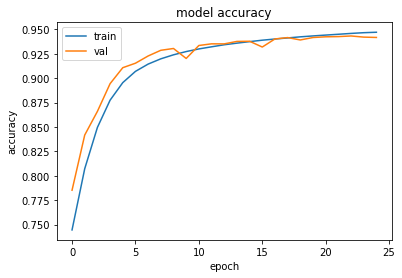

<Figure size 432x288 with 0 Axes>

In [131]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('trai_validation_accuracy')

**Prediction**

In [132]:
from keras.models import load_model

In [133]:
# Load the Best Model

model = load_model('/content/drive/MyDrive/Punjabi transliteration/NMT_model.hdf5')

In [134]:
english_tensor_predicted = np.argmax(model.predict(punjabi_tensor_test),axis=-1)

1609/1609 [==============================] - 12s 6ms/step


In [135]:
english_tensor_predicted

array([[ 2, 18,  8, ...,  0,  0,  0],
       [ 2, 23, 16, ...,  0,  0,  0],
       [ 2, 25, 12, ...,  0,  0,  0],
       ...,
       [ 2, 10, 22, ...,  0,  0,  0],
       [ 2, 18, 16, ...,  0,  0,  0],
       [ 2, 14,  8, ...,  0,  0,  0]])

Evaluating test function

In [136]:
m = tf.keras.metrics.Accuracy()
m.update_state(english_tensor_test, english_tensor_predicted)
m.result().numpy()

0.9433858

In [6]:
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pickle 

model = load_model('pun_to_eng.hdf5') 
with open('punjabi_vocab_to_int.pickle', 'rb') as handle:
    punjabi_vocab_to_int = pickle.load(handle)

with open('english_int_to_vocab.pickle', 'rb') as handle:
    english_int_to_vocab = pickle.load(handle)

def predict(text):
    word_pred = []
    text=text.split()
    text = ['@' + item + '#' for item in text]
    for i in text:
    # Convert the new input sentence to a tensor using the Word2Index objects
        new_input_tensor = [[punjabi_vocab_to_int.get(char, punjabi_vocab_to_int['<pad>']) for char in i]]
        # Pad the tensor to the maximum length
        new_input_tensor = tf.keras.preprocessing.sequence.pad_sequences(new_input_tensor, maxlen=24, padding='post')
        english_tensor_predicted = np.argmax(model.predict(new_input_tensor),axis=-1)
    
        for i in english_tensor_predicted[0]:
           word_pred.append(english_int_to_vocab[i])
    return word_pred

In [9]:
s=predict("ਪੰਜਾਬੀ ਯੂਨੀਵਰਸਿਟੀ ਪਟਿਆਲਾ")


1/1 [==============================] - 0s 53ms/step


In [10]:
name = ""
l=[]
# Iterate over the characters in the list
for char in s:
    # Check if the character is "@"
    if char == "@":
        # Reset the name variable
        name = ""
    # Check if the character is "#"
    elif char == "#":
        # Print the stored name
        l.append(name)
        # print(name, end=" ")
    # If the character is not "@" or "#", add it to the name variable
    else:
        name += char

In [11]:
prev = None
result = []
for item in l:
    if item != prev:
        result.append(item)
    prev = item
print(" ".join(result))

panjabi university patiala
